# Clinical interpretation of cancer somatic mutatios using Semi-Supervised Generative Adversarial Model

In [1]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tqdm
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('the device is %s' % device)

from tensorboardX import SummaryWriter
prefix = 'a-test'


from myLibs import myTrainPrep

the device is cuda


### load the training data

Note:
* When the labeled batch size is 4k and unlabeled batch size is 10k, the used memory of GPU is ~6Gb.
* Training 2000 epochs with 200 batch size on NVIDIA 1080Ti, the whole process will take 4 hours. 

In [2]:
shuffle_seed      = 37

## the size of labeled data for training
pos_size          = 1000
neg_size          = 3000
train_size        = pos_size + neg_size

## batch size
batch_size        = 4000

## no. of epoch
num_epochs = 10

In [3]:
label_feature = pd.read_csv("./myData/Marilyn-std0.02/labeled.csv").values
label_target  = pd.read_csv("./myData/Marilyn-std0.02/true_label.csv").values.reshape(-1)

pos_feature = label_feature[label_target == 1]
pos_label   = label_target[label_target == 1]
print(pos_feature.shape)
neg_feature = label_feature[label_target == 0]
neg_label   = label_target[label_target == 0]
print(neg_feature.shape)

train_x = np.array(list(pos_feature[0:pos_size]) + list(neg_feature[0:neg_size]))
print(train_x.shape)
train_y = np.array(list(pos_label[0:pos_size])   + list(neg_label[0:neg_size]))

np.random.seed(shuffle_seed)
np.random.shuffle(train_x)
np.random.seed(shuffle_seed)
np.random.shuffle(train_y)


valid_x = np.array(list(pos_feature[pos_size:]) + list(neg_feature[neg_size:]))
valid_y = np.array(list(pos_label[pos_size:]) + list(neg_label[neg_size:]))

np.random.seed(shuffle_seed)
np.random.shuffle(valid_x)
np.random.seed(shuffle_seed)
np.random.shuffle(valid_y)

labeled_loader = myTrainPrep.labeled_batch_creator(train_x, train_y, batch_size, -1)
valided_loader = myTrainPrep.labeled_batch_creator(valid_x, valid_y, batch_size, -1)

(1668, 71)
(3566, 71)
(4000, 71)


### load unlabeled data
Here, we used 60k unlabeled data in training process.

In [4]:
unlabel_data  = pd.read_csv("./myData/Marilyn-std0.02/unlabel.csv").sample(n=60000, replace=False, axis=0, random_state=1).values

np.random.seed(shuffle_seed)
np.random.shuffle(unlabel_data)
unlabeled_loader = myTrainPrep.unlabeled_batch_creator(unlabel_data, batch_size)

### load model

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


from myLibs.myGen import NetG7
from myLibs.myDis import model3_1
modelCD     = model3_1().to(device)
modelG      = NetG7(batch_size).to(device)
modelCD.apply(weights_init)
modelG.apply(weights_init)
optimizerCD = optim.Adam(modelCD.parameters(), lr=0.00095, betas=(0.5, 0.999), weight_decay = .001)
optimizerG  = optim.Adam(modelG.parameters(),  lr=0.00095, betas=(0.5, 0.999), weight_decay = .001)

print(modelCD)
print(modelG)

CNN1d_5layer(
  (cnn1): Sequential(
    (0): Conv1d(1, 10, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.3, inplace=False)
  )
  (cnn2): Sequential(
    (0): Conv1d(10, 40, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout(p=0.3, inplace=False)
  )
  (cnn3): Sequential(
    (0): Conv1d(40, 200, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear1): Sequential(
    (0): Linear(in_features=13000, out_features=2, bias=True)
  )
)
NetG7(
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
  (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=False)
  (ln3): LayerNorm((512,), eps=1e-05, elementwise_affine=False)
  (Linear1): Sequential(
    (0): Linear(in_features=30, out_features=128

### Training process

- We use [tensorboardX](https://pytorch.org/docs/stable/tensorboard.html) to track and visulize the losses and accuracies during training.
- The loss functions used in this training process are based on the paper [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498)


To visulize the losses using tensorboardx:
```bash
tensorboard --logdir=runs
```
And then click the link.

In [6]:

writer = SummaryWriter(comment="%s" % prefix)

global_step = 1

for epoch in tqdm.tqdm(range(num_epochs)):
    for step in range(len(unlabeled_loader)):
        #################################################################################  Discriminator
        modelCD.train()
        modelG.eval()
        optimizerCD.zero_grad()

        ## label
        labeled_dict     = labeled_loader[0]
        x_labeled        = labeled_dict['data'][:, np.newaxis, :].to(device)
        y_labeled        = labeled_dict['target'].to(device)
        y_pred_labeled   = modelCD(x_labeled)  
        pdist   = y_pred_labeled.gather(1, y_labeled.view(-1, 1)).squeeze(1)
        labeled = torch.logsumexp(y_pred_labeled, dim=1)
        lossS   = -torch.mean(pdist) + torch.mean(labeled)
        
        
        ## unlabel
        unlabeled_dict  = unlabeled_loader[step]
        x_unlabeled     = unlabeled_dict['data'][:, np.newaxis, :].to(device)
        y_unlabeled     = unlabeled_dict['target'].to(device)
        outClassUnlabeled  = modelCD(x_unlabeled)
        
        logz_unlabeled = torch.logsumexp(outClassUnlabeled, dim=1)
        lossUnlabeled  = 0.5 * ( -torch.mean(logz_unlabeled) + torch.mean(F.softplus(logz_unlabeled)) )
        
        ## Fake
        fakeNoise1 = torch.randn(x_unlabeled.size(0), 30, device=device)
        x_Fake1    = ( modelG(fakeNoise1) + 1.0 ) / 2
        outClassFake1 = modelCD(x_Fake1.detach())

        logz_fake1 = torch.logsumexp(outClassFake1, dim=1)
        lossFake  = 0.5 * torch.mean(F.softplus(logz_fake1))
        
        ## loss
        lossU      = lossUnlabeled + lossFake
        lossD = lossU + lossS
        
        writer.add_scalar("training_loss/supervised", lossS, global_step)
        writer.add_scalar("training_loss/unsupervised", lossU, global_step)        
        writer.add_scalar("training_loss/lossD", lossD, global_step)
        
        
        lossD.backward()
        optimizerCD.step()
        
                
        #################################################################################  Generator
        modelCD.eval()
        modelG.train()
        optimizerG.zero_grad()
        
        ## loss
        y_pred_unlabeled = modelCD(x_unlabeled)
        y_pred_fake      = modelCD(x_Fake1)
        
        mom_real = torch.mean(y_pred_unlabeled, dim=0)
        mom_fake = torch.mean(y_pred_fake, dim=0)
        diff = mom_fake - mom_real
        lossG = torch.mean(diff * diff)

        
        ## optimization
        writer.add_scalar("training_loss/lossG", lossG, global_step)
        
        
        lossG.backward()        
        optimizerG.step()
        
        
        global_step += 1
        
    
    
    train_loss, train_accuracy = myTrainPrep.myPerform(modelCD, device, labeled_loader)
    writer.add_scalar("accuracy/train", train_accuracy, epoch)

    test_loss, test_accuracy = myTrainPrep.myPerform(modelCD, device, valided_loader)
    writer.add_scalar("accuracy/test", test_accuracy, epoch)

    
writer.flush()
writer.close()

100%|██████████| 10/10 [01:11<00:00,  7.13s/it]


In [ ]:
# torch.save(modelCD.state_dict(), './model_save/%s.pt' % title_name)

### 

### validation performance

In [7]:
import math
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score


def myEval(model, device, test_loader, display = False):
    model.eval()
    
    target_list = []
    output_list = []
    
    with torch.no_grad():
        for batch in test_loader:
            data = batch['data'][:, np.newaxis, :].to(device)
            target = batch['target'].to(device)
            output = model(data)
            softmax2_score = [ math.exp(i[1]) / ( math.exp(i[0]) + math.exp(i[1]) ) for i in output.cpu().numpy() ]
            target_list += target.cpu().tolist()
            output_list += softmax2_score

    return target_list, output_list


def evaluation_df(pred_score, labeled_y):
    def TP_table(pred_score, labeled_y, threshold):
        y_pred = [0 if i < threshold else 1 for i in pred_score]
        y_true = list(labeled_y)


        fpr, tpr, _ = roc_curve(y_true, pred_score)
        auc_val = auc(fpr, tpr)


        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        # TP TN FP FN sensitivity specificity Accuracy
        sensitivity = tp/(tp+fn)

        specificity = tn/(tn+fp)
        accuracy    = (tp+tn)/(tp+tn+fp+fn)
        
        F1 = f1_score(y_true, y_pred)
        
        try:
            MCC = ((tp*tn)-(fp*fn)) / ((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5
        except:
            MCC = np.nan

        return [threshold, tp, fp, tn, fn, sensitivity, specificity, accuracy, auc_val, MCC, F1]

    res = []
    for i in range(1,20):
        threshold = i / 20
        res.append(TP_table(pred_score, labeled_y, threshold))

    res = pd.DataFrame(res, columns=['threshold', 'TP', 'FP', 'TN', 'FN', 'sen', 'spe', 'Acc', 'AUC', 'MCC', 'F1'])
    return res


In [8]:
label, pred = myEval(modelCD, device, valided_loader)
evaluation_df(pred, label)

,threshold,TP,FP,TN,FN,sen,spe,Acc,AUC,MCC,F1
0,0.05,609,44,522,59,0.911677,0.922261,0.916532,0.969459,0.832503,0.922029
1,0.10,577,25,541,91,0.863772,0.955830,0.905997,0.969459,0.817040,0.908661
2,0.15,558,17,549,110,0.835329,0.969965,0.897083,0.969459,0.804404,0.897828
3,0.20,545,15,551,123,0.815868,0.973498,0.888169,0.969459,0.790044,0.887622
4,0.25,534,13,553,134,0.799401,0.977032,0.880875,0.969459,0.778804,0.879012
5,0.30,521,12,554,147,0.779940,0.978799,0.871151,0.969459,0.763249,0.867610
6,0.35,508,9,557,160,0.760479,0.984099,0.863047,0.969459,0.751972,0.857384
7,0.40,498,9,557,170,0.745509,0.984099,0.854943,0.969459,0.738950,0.847660
8,0.45,483,7,559,185,0.723054,0.987633,0.844408,0.969459,0.723752,0.834197
9,0.50,465,6,560,203,0.696108,0.989399,0.830632,0.969459,0.703130,0.816506


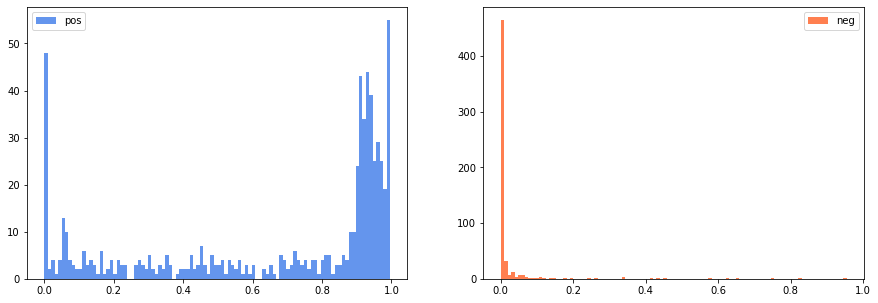

In [9]:
pos_arr = np.array(pred)[np.array(label)==1]
neg_arr = np.array(pred)[np.array(label)==0]

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(pos_arr, bins=100, label='pos', color='cornflowerblue')
plt.legend()
plt.subplot(1,2,2)
plt.hist(neg_arr, bins=100, label='neg', color='coral')
plt.legend()
plt.show()

### test on 6k data

In [10]:
label_feature = pd.read_csv("./myData/Test6k/labeled.csv").values
label_target  = pd.read_csv("./myData/Test6k/true_label.csv").values.reshape(-1)

test_loader = myTrainPrep.labeled_batch_creator(label_feature, label_target, 300, -1)
label, pred = myEval(modelCD, device, test_loader)
evaluation_df(pred, label)

,threshold,TP,FP,TN,FN,sen,spe,Acc,AUC,MCC,F1
0,0.05,1186,2277,2614,149,0.888390,0.534451,0.610344,0.856633,0.349301,0.494373
1,0.10,1138,1787,3104,197,0.852434,0.634635,0.681336,0.856633,0.400539,0.534272
2,0.15,1089,1313,3578,246,0.815730,0.731548,0.749598,0.856633,0.461426,0.582820
3,0.20,1042,1007,3884,293,0.780524,0.794112,0.791198,0.856633,0.501914,0.615839
4,0.25,986,813,4078,349,0.738577,0.833776,0.813363,0.856633,0.518243,0.629228
5,0.30,962,658,4233,373,0.720599,0.865467,0.834404,0.856633,0.548235,0.651100
6,0.35,940,575,4316,395,0.704120,0.882437,0.844202,0.856633,0.561031,0.659649
7,0.40,911,524,4367,424,0.682397,0.892864,0.847735,0.856633,0.560616,0.657762
8,0.45,869,457,4434,466,0.650936,0.906563,0.851751,0.856633,0.558874,0.653138
9,0.50,831,400,4491,504,0.622472,0.918217,0.854802,0.856633,0.557173,0.647701


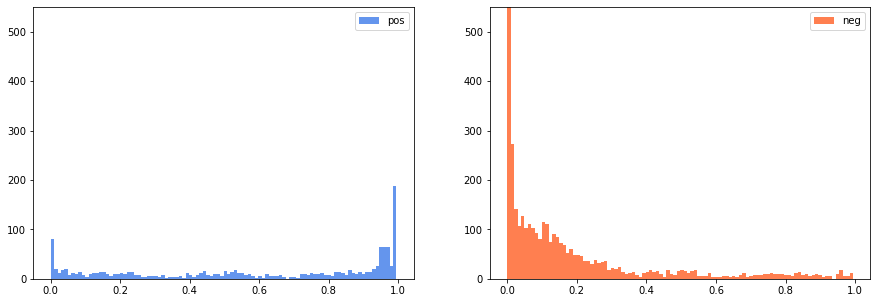

In [11]:
pos_arr = np.array(pred)[np.array(label)==1]
neg_arr = np.array(pred)[np.array(label)==0]

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.hist(pos_arr, bins=100, label='pos', color='cornflowerblue')
plt.ylim(0,550)
plt.legend()
plt.subplot(1,2,2)
plt.hist(neg_arr, bins=100, label='neg', color='coral')
plt.ylim(0,550)
plt.legend()
plt.show()